In [47]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

client = MongoClient('localhost:27017')
db = client.hiwi
collection = db.production_steps

database = {}
database['features'] = {}
index = []

query_1 = {"$and": [{"type": "formation"}, {"substep": "soacking"}, {"features": {"$exists": True}}]}
query_1 = list(collection.find(query_1))
database['features']['soacking_state'] = []
database['features']['soacking_success'] = []
database['features']['soacking_start_voltage'] = []
for i in range(len(query_1)):
    database['features']['soacking_state'].append(query_1[i]['features'][0]['value'])
    database['features']['soacking_success'].append(query_1[i]['features'][1]['value'])
    database['features']['soacking_start_voltage'].append(query_1[i]['features'][2]['value'])
    index.append(query_1[i]['cell_id'])

query_2 = {"$and": [{"type": "formation"}, {"substep": "precharge"}, {"features": {"$exists": True}}]}
query_2 = list(collection.find(query_2))
database['features']['precharge_start_voltage'] = []
database['features']['precharge_duration'] = []
database['features']['precharge_energy'] = []
database['features']['precharge_success'] = []
database['features']['precharge_continuity'] = []
for i in range(len(query_2)):
    database['features']['precharge_start_voltage'].append(query_2[i]['features'][0]['value'])
    database['features']['precharge_duration'].append(query_2[i]['features'][1]['value'])
    database['features']['precharge_energy'].append(query_2[i]['features'][2]['value'])
    database['features']['precharge_success'].append(query_2[i]['features'][3]['value'])
    database['features']['precharge_continuity'].append(query_2[i]['features'][4]['value'])

query_3 = {"$and": [{"type": "formation"}, {"substep": "charge"}, {"features": {"$exists": True}}]}
query_3 = list(collection.find(query_3))
database['features']['charge_start_voltage'] = []
database['features']['charge_duration'] = []
database['features']['charge_energy'] = []
database['features']['charge_success'] = []
database['features']['charge_continuity'] = []
for i in range(len(query_3)):
    database['features']['charge_start_voltage'].append(query_3[i]['features'][0]['value'])
    database['features']['charge_duration'].append(query_3[i]['features'][1]['value'])
    database['features']['charge_energy'].append(query_3[i]['features'][2]['value'])
    database['features']['charge_success'].append(query_3[i]['features'][3]['value'])
    database['features']['charge_continuity'].append(query_3[i]['features'][4]['value'])

query_4 = {"$and": [{"type": "formation"}, {"substep": "discharge"}, {"features": {"$exists": True}}]}
query_4 = list(collection.find(query_4))
database['features']['discharge_start_voltage'] = []
database['features']['discharge_duration'] = []
database['features']['discharge_energy'] = []
database['features']['discharge_success'] = []
database['features']['discharge_continuity'] = []
for i in range(len(query_4)):
    database['features']['discharge_start_voltage'].append(query_4[i]['features'][0]['value'])
    database['features']['discharge_duration'].append(query_4[i]['features'][1]['value'])
    database['features']['discharge_energy'].append(query_4[i]['features'][2]['value'])
    database['features']['discharge_success'].append(query_4[i]['features'][3]['value'])
    database['features']['discharge_continuity'].append(query_4[i]['features'][4]['value'])

data = pd.DataFrame(database['features'])

class_le = LabelEncoder()
for column in data[['soacking_state', 'precharge_continuity', 'charge_continuity', 'discharge_continuity', 'soacking_success', 'precharge_success', 'charge_success', 'discharge_success']].columns:
    data[column] = class_le.fit_transform(data[column].values)

# get all features and store them into dataframe
data['index'] = index
data = data.sort_values(by = ['index'])
data = data.drop(['index'], axis = 1)

# apply pca
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(data)

pca = PCA(n_components=6)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)

data_pca = pd.concat([data.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pca.columns.values[-6: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6']
data = data_pca[['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6']]

In [9]:
data.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6
0,-8.651758,9.800816,2.073419,1.784903,-0.112717,3.332457
1,-1.313052,1.398527,-0.404467,-1.153597,-0.284673,-0.635345
2,-1.609867,0.601834,-1.231057,-0.383825,0.028344,-1.439034
3,-0.759540,-0.055339,-0.625979,-0.715569,-0.226652,-0.434100
4,-1.156154,0.396405,-1.006402,0.462086,0.098135,0.121363


In [37]:
labels = pd.read_csv("/Users/rampageyao/Desktop/crino/crino_state/Conditioning_PCA_Kmeans_label.csv")
labels = (labels.iloc[:, 2]).tolist()
data['labels'] = labels
data.head()

<ipython-input-37-72ea189a2748>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = labels


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,labels
0,-8.651758,9.800816,2.073419,1.784903,-0.112717,3.332457,2
1,-1.313052,1.398527,-0.404467,-1.153597,-0.284673,-0.635345,4
2,-1.609867,0.601834,-1.231057,-0.383825,0.028344,-1.439034,4
3,-0.759540,-0.055339,-0.625979,-0.715569,-0.226652,-0.434100,0
4,-1.156154,0.396405,-1.006402,0.462086,0.098135,0.121363,4


In [43]:
sc = StandardScaler()
train, test = train_test_split(data, test_size=0.3)
X_train, y_train = train.iloc[:, 0:6], train.iloc[:, 6]
X_test, y_test = test.iloc[:, 0:6], test.iloc[:, 6]

#sm = SMOTE()
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [44]:
ranFor = RandomForestClassifier()
grid=[{'n_estimators':[3,5,8,10,13,15,18,20,25,40,60,80,100],'max_features':['auto','sqrt'],'max_depth':[None,1,3,5,7,10,15,20]}]
ranFor_CV=GridSearchCV(ranFor,grid,cv=10)
ranFor_CV.fit(X_train,y_train.values.ravel())
ranFor.fit(X_train,y_train.values.ravel())

print("Best Score Random Forest: {:.2f}".format(ranFor_CV.best_score_))
print("Best Parameters Random Forest:",ranFor_CV.best_params_)

/Users/rampageyao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Best Score Random Forest: 0.42
Best Parameters Random Forest: {'max_depth': 1, 'max_features': 'auto', 'n_estimators': 15}


Test accuracy: 0.08695652173913043


<Figure size 432x288 with 0 Axes>

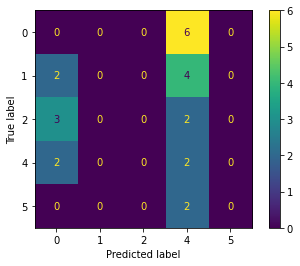

In [49]:
y_pred_rF = ranFor_CV.best_estimator_.predict(X_test)

print("Test accuracy:",accuracy_score(y_test,y_pred_rF))
cnf_matrix_rF = metrics.confusion_matrix(y_test, y_pred_rF)
plt.figure()
plot_confusion_matrix(ranFor_CV,X_test,y_test)